In [1]:
import pyccl as ccl
print(f"I am using pyccl version {ccl.__version__}")
import numpy as np
import matplotlib.pyplot as plt
from scripts.presets import Presets
from scripts.data_vectors import DataVectors
from scripts.data_vector_metrics import DataVectorMetrics
import emcee

I am using pyccl version 3.0.2


In [2]:
forecast_year = "1"
presets = Presets(forecast_year=forecast_year, should_save_data=False)
data = DataVectors(presets)
cl_gc = np.array(data.galaxy_clustering_cls(include_all_correlations=True))
cl_ggl = np.array(data.galaxy_galaxy_lensing_cls(include_all_correlations=True))
cl_cs = np.array(data.cosmic_shear_cls(include_all_correlations=True))
metric = DataVectorMetrics(presets)
cls_noise = metric.get_matrix(cl_gc, cl_ggl, cl_cs, True)

def likelihood(params):
    Om = params[0]
    Ob = params[1]
    h = params[2]
    sigma8 = params[3]
    n_s = params[4]
    w0 = params[5]
    wa = params[6]
    if Ob >= Om or Ob <= 0 or Om <= 0 or sigma8 <= 0:
        return -np.inf
    try:
        cosmo = ccl.Cosmology(Omega_c=(Om-Ob),
                                Omega_b=Ob,
                                h=h,
                                sigma8=sigma8,
                                n_s=n_s,
                                w0=w0,
                                wa=wa)
        
        presets_mc = Presets(cosmology=cosmo, forecast_year=forecast_year, should_save_data=False)
        
        #presets_mc = Presets(cosmology=cosmo,redshift_resolution=600, forecast_year=forecast_year, should_save_data=False)
        data = DataVectors(presets_mc)
        cl_gc_mc = np.array(data.galaxy_clustering_cls(include_all_correlations=True))
        cl_ggl_mc = np.array(data.galaxy_galaxy_lensing_cls(include_all_correlations=True))
        cl_cs_mc = np.array(data.cosmic_shear_cls(include_all_correlations=True))
        metric = DataVectorMetrics(presets_mc)
        cls = metric.get_matrix(cl_gc_mc, cl_ggl_mc, cl_cs_mc, True)
        return metric.get_loglike(cls, cls_noise)
    except:
        return -np.inf




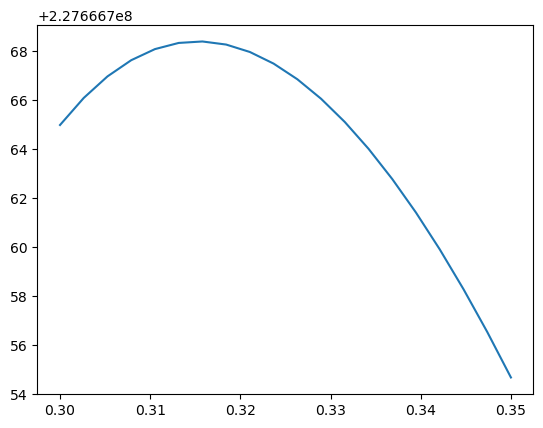

In [3]:

pos = [0.3156, 0.049,0.6727,0.831,0.9645,-1,0.0] 

omega_m = np.linspace(0.3,0.35,20)
ll = np.zeros_like(omega_m)
for i in range(len(omega_m)):
    pos[0] = omega_m[i]
    ll[i] = likelihood(pos)

plt.plot(omega_m,ll)